# Delayed Image Quickstart

Lets say you have some image. Maybe it is a very large image, but maybe not.
Either way, you have a path to it.

In [1]:
import delayed_image
import kwimage
import kwplot
import ubelt as ub

In [2]:
# Given a path to some image
fpath = kwimage.grab_test_image_fpath('amazon')
print(ub.Path(fpath).shrinkuser())

~/.cache/kwimage/demodata/amazon.jpg


(<Figure size 432x288 with 1 Axes>, <AxesSubplot: >)

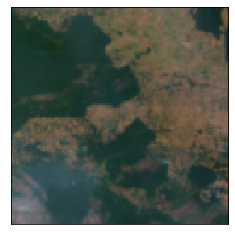

In [3]:
### We are ultimately going to load a cropped downsampled part of the above image.
### We can do so like this:
delayed = delayed_image.DelayedLoad(fpath)
delayed = delayed.prepare()
delayed = delayed.scale(0.1)
delayed = delayed[128:256, 128:256]

kwplot.imshow(delayed.finalize())

### The rest of this tutorial will dive into the details of what is happening here


## The DelayedLoad object
Perhaps there are a series of operations you want to perform on the image.
To start create an instance of a `DelayedLoad` object.

This simply stores the path to the image. We can also pass it extra information about the image if we know it a-priori, like the shape and number of / names of the channels. See the docstring for details:

```   
Points to an image on disk to be loaded.

Args:
    fpath (str | PathLike):
        URI pointing at the image data to load

    channels (int | str | FusedChannelSpec | None):
        the underlying channels of the image if known a-priori

    dsize (Tuple[int, int]):
        The width / height of the image if known a-priori

    nodata_method (str | None):
        How to handle nodata values in the file itself.
        Can be "auto", "float", or "ma".
```

In [4]:
# A simple reference to the underlying data
delayed = delayed_image.DelayedLoad(fpath)
print(delayed)

<DelayedLoad((None, None, None))>


In [5]:
# If you don't provide the underlying meta a-priori,
# most of it can be introspected 
delayed.prepare()

<DelayedLoad((3000, 3836, 3)) at 0x7f79527fed70>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot: >)

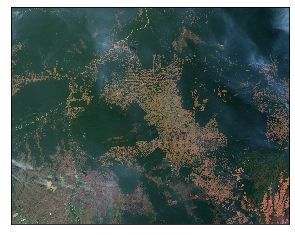

In [6]:
# At any point you can "finalize" a DelayedImage object
imdata = delayed.finalize()
kwplot.imshow(imdata)

## DelayedOperations

The ``DelayedLoad`` class is an instance of a ``DelayedImage``, all of which have the following methods:

* shape - returns the shape of the data if it was finalized
* warp - applies an affine transform (scale, translate, rotate, shear) to the underlying data.  
* crop - return only a subimage from the larger dataset

among others (i.e. `scale`, `resize`, `dequantize`, ...)

If we want to zoom into a specific region we can start by cropping and then scaling.

╙── Crop dsize=(1536,512),space_slice=(slice(512,1024,None),slice(512,2048,None))

└─╼ Load num_channels=3,dsize=(3836,3000),num_overviews=4,fname=amazon.jpg

(<Figure size 432x288 with 1 Axes>, <AxesSubplot: >)

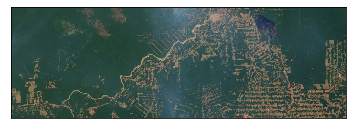

In [7]:
# A crop operation can be performed simply by slicing
cropped = delayed[512:1024, 512:2048]

# The result doesn't do anything, each operation returns a new delayed computation tree, 
# which we can inspect using ``write_network_text``.
cropped.write_network_text()

# And again, we can finalize at any point
kwplot.imshow(cropped.finalize())

╙── Warp dsize=(77,26),transform={scale=0.0500}

└─╼ Crop dsize=(1536,512),space_slice=(slice(512,1024,None),slice(512,2048,None))

└─╼ Load num_channels=3,dsize=(3836,3000),num_overviews=4,fname=amazon.jpg

(<Figure size 432x288 with 1 Axes>, <AxesSubplot: >)

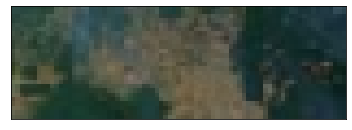

In [8]:
# Adding a scale operation lets us upsample or downsample.
scaled = cropped.scale(0.05, interpolation='nearest')

# We can inspect the new operation tree and the new image.
scaled.write_network_text()
kwplot.imshow(scaled.finalize())

╙── Crop dsize=(50,50),space_slice=(slice(0,50,None),slice(0,50,None))

└─╼ Warp dsize=(154,52),transform={scale=2.0000}

└─╼ Warp dsize=(77,26),transform={scale=0.0500}

└─╼ Crop dsize=(1536,512),space_slice=(slice(512,1024,None),slice(512,2048,None))

└─╼ Load num_channels=3,dsize=(3836,3000),num_overviews=4,fname=amazon.jpg

(<Figure size 432x288 with 1 Axes>, <AxesSubplot: >)

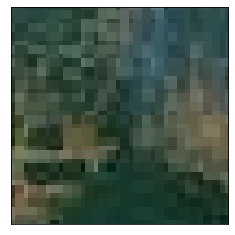

In [9]:
# Adding a scale operation lets us upsample or downsample, and maybe we want to crop once more...
rescaled = scaled.scale(2.0, interpolation='nearest')
recropped = rescaled[0:50, 0:50]

# We can inspect the new operation tree and the new image.
recropped.write_network_text()
kwplot.imshow(recropped.finalize())

It is imporant to note, that the above series of operations is not exactly what happens under the hood. We don't simply load the image and perform each operation one-by-one. We could force that to happend, but by default delayed image will **optimize** the computation tree by fusing and reordering the nodes to most efficiently apply the set of operations while minimizing resampling artifacts. The optimization is also aware of if the underlying image has tiles or overviews (e.g. a Cloud Optimized Geotiff) and will leverage those structures to minimize the computation necessary.

In the following example notice how:

* An overview is used to make scaling more efficient.
* All crops are reordered and fused such that cropping happens immediately after loading.
* All scalings are reordered and fused to operate on the minimum amount of data.

In [10]:
# We can show the optimized tree by using the optimized method 
# (notice the overview node is inserted to make the scaling more efficient)
recropped.optimize().write_network_text()

╙── Warp dsize=(50,50),transform={scale=1.6000}

└─╼ Crop dsize=(32,32),space_slice=(slice(32,64,None),slice(32,64,None))

└─╼ Overview dsize=(240,188),overview=4

└─╼ Load num_channels=3,dsize=(3836,3000),num_overviews=4,fname=amazon.jpg

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot: title={'center': 'optimized finalize'}>)

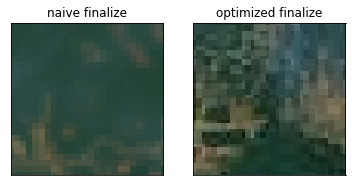

In [11]:
# We can also compare the naive sequence of operations to the optimized variant.

kwplot.imshow(recropped.finalize(optimize=False), pnum=(1, 2, 1), title='naive finalize')
kwplot.imshow(recropped.finalize(optimize=True), pnum=(1, 2, 2), title='optimized finalize')